# 机场接驳数据预处理
 Author：吕迪 <p>Time： 2023.8

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [24]:
import pandas as pd
import numpy as np
from pathlib import Path
from shapely.geometry import Point, Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import os
import os.path
import yaml

In [4]:
def get_coordinate(df,zoneid_col):
    "将方格转换为中心点经纬度，可以看到方格的"
    df['ymin']=df[zoneid_col]//614258*0.0001+18.163240
    df['ymax']=df['ymin']+0.0001
    df['xmin']=df[zoneid_col]%614258*0.0001+73.451000
    df['xmax']=df['xmin']+0.0001
    df['clat']=df['ymin']+0.00005
    df['clng']=df['xmin']+0.00005
    return df

In [5]:
def Distance(slng, slat, elng, elat):
    slng1=np.array(slng)*2*np.pi/360
    slat1=np.array(slat)*2*np.pi/360
    elng1=np.array(elng)*2*np.pi/360
    elat1=np.array(elat)*2*np.pi/360
    lng = elng1 - slng1
    lat = elat1 - slat1
    d = (np.sin(lat * 0.5) ** 2 + np.cos(slat1) * np.cos(elat1) * np.sin(lng * 0.5) ** 2)
    return 2 *6371.0088* np.arcsin(d ** 0.5)  


In [6]:
def trip_extraction(df):
    """
    """
    df['stime'] = pd.to_datetime(df['stime'])
    df['etime'] = pd.to_datetime(df['etime'])
    df = df.sort_values(['user_id', 'stime']) 

    df_trip = pd.DataFrame()
    df_trip['suser_id'] = df['user_id'].values[:-1]
    df_trip['euser_id'] = df['user_id'].values[1:]

    df_trip['sZoneID'] = df['grid_id'].values[:-1]
    df_trip['eZoneID'] = df['grid_id'].values[1:]
    df_trip['stime']   = df['etime'].values[:-1]
    df_trip['etime']   = df['stime'].values[1:]
    print(df_trip.shape)
    df_trip = df_trip[df_trip['suser_id'] == df_trip['euser_id']].copy()
    print(df_trip.shape)

    df_trip = df_trip.drop(columns=['euser_id'])
    df_trip = df_trip.rename(columns={"suser_id":"user_id"})  

    df_trip = get_coordinate(df_trip, 'sZoneID')
    df_trip = df_trip.rename(columns={c:f"s{c}" for c in ['clng', 'clat'] })
    df_trip = get_coordinate(df_trip, 'eZoneID')
    df_trip = df_trip.rename(columns={c:f"e{c}" for c in ['clng', 'clat'] })
    df_trip = df_trip.drop(columns = ['ymin', 'ymax', 'xmin', 'xmax'])
    df_trip['line_dis'] = Distance(df_trip['sclng'], df_trip['sclat'], df_trip['eclng'], df_trip['eclat']) * 1000
    return df_trip

In [7]:
def is_point_inside_polygon(point, polygon):
    return polygon.contains(point)

In [8]:
def data_clean(trip_data):
    trip_data['start_point'] = trip_data.apply(lambda row: Point(row['sclng'], row['sclat']), axis=1)
    trip_data['end_point'] = trip_data.apply(lambda row: Point(row['eclng'], row['eclat']), axis=1)
    new_data= trip_data[((trip_data['start_point'].apply(lambda point: is_point_inside_polygon(point, rectangle_polygon))) &
                          ~(trip_data['end_point'].apply(lambda point: is_point_inside_polygon(point, rectangle_polygon)))) |
                          (~(trip_data['start_point'].apply(lambda point: is_point_inside_polygon(point, rectangle_polygon))) &
                          (trip_data['end_point'].apply(lambda point: is_point_inside_polygon(point, rectangle_polygon))))]
    new_data['delta_time']=new_data['etime']-new_data['stime']
    
    temp=new_data.copy()
    st=pd.to_datetime('2020-10-01 00:00:00')
    et=pd.to_datetime('2020-10-31 23:59:00')
    temp=temp[(temp['stime']>=st)&(temp['stime']<et)&(temp['etime']>=st)&(temp['etime']<et)]
    
    mindet=pd.to_timedelta('15 minutes')
    maxdet=pd.to_timedelta('150 minutes')
    temp=temp[(temp['delta_time']>mindet)&(temp['delta_time']<maxdet)]
    
    temp=temp[temp['line_dis']>5000]
    
    start=temp[temp['end_point'].apply(lambda point: is_point_inside_polygon(point, rectangle_polygon))].copy()
    end=temp[temp['start_point'].apply(lambda point: is_point_inside_polygon(point, rectangle_polygon))].copy()
    print(start.shape)
    print(end.shape)
    
    return start,end
    

#### 针对一个数据可用，并不执行

In [27]:
gpd.options.use_pygeos=False
start_gdf=gpd.GeoDataFrame(start['user_id'], geometry=start['start_point'])
end_gdf=gpd.GeoDataFrame(end['user_id'], geometry=end['end_point'])
poly=gpd.GeoDataFrame(geometry=[rectangle_polygon])
all_gdf=pd.concat([start_gdf,end_gdf])

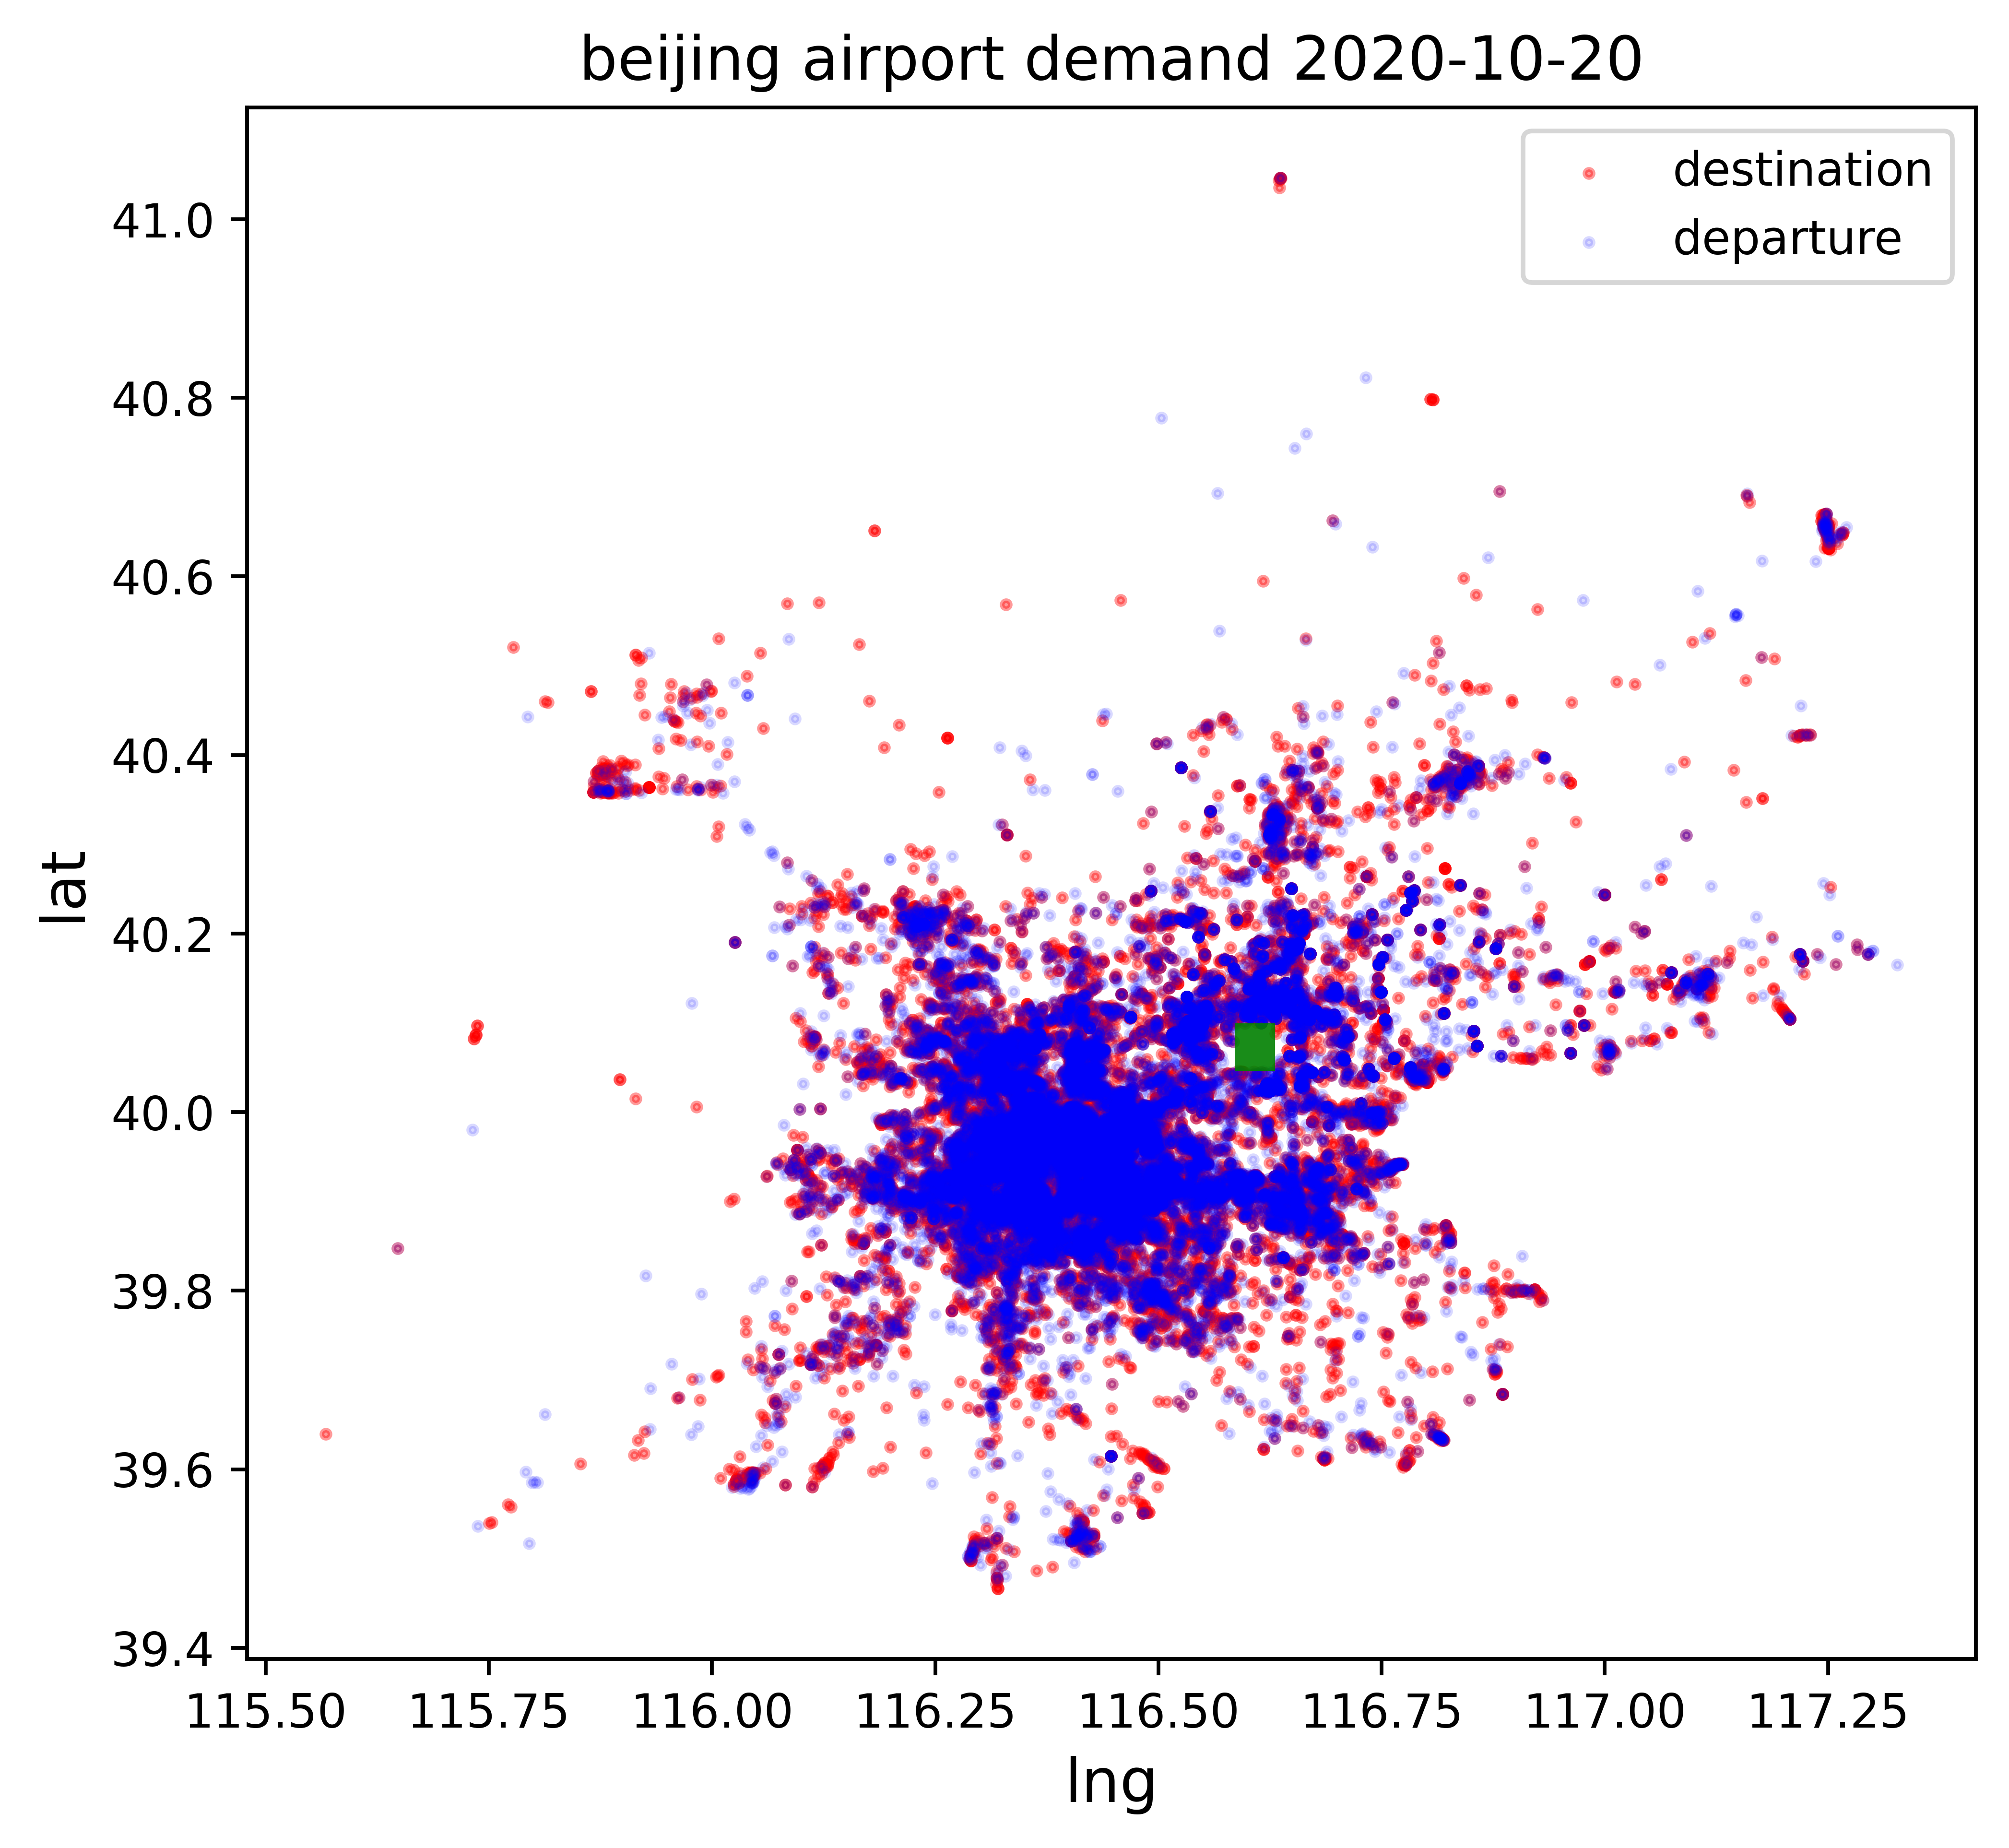

In [28]:
fig,ax=plt.subplots(figsize=(10,6),dpi=700)
ax.set_aspect('equal')
start_gdf.plot(ax=ax,color='red',markersize=3,alpha=0.4,label='destination')
end_gdf.plot(ax=ax,color='blue',markersize=3,alpha=0.15,label='departure')
poly.plot(ax=ax,color='green',alpha=0.9,label='start')
plt.title("beijing airport demand 2020-10-20",fontsize=13)
plt.xlabel("lng",fontsize=13)
plt.ylabel("lat",fontsize=13)
plt.legend()

In [9]:
def calculate_time_index(row):
    hour=row['stime'].hour
    minu=row['stime'].minute
    step=4
    index=hour*4+minu//15+1
    return index

In [10]:
def point_to_zone(start,end):
    start=start.drop(columns=['sZoneID','eZoneID','eclat','eclng','end_point'])
    end=end.drop(columns=['sZoneID','eZoneID','sclat','sclng','start_point'])
    start=start.rename(columns={"sclat":"clat","sclng":"clng"})
    end=end.rename(columns={"eclat":"clat","eclng":"clng"})
    
#     lng_all=pd.concat([start['clng'],end['clng']])
#     lat_all=pd.concat([start['clat'],end['clat']])
#     bound_lng=[lng_all.min(),lng_all.max()]
#     bound_lat=[lat_all.min(),lat_all.max()]  
    
    xstep=(maxlng-minlng)/num_x_division
    ystep=(maxlat-minlat)/num_y_division
    x_lines=int((bound_lng[1]-bound_lng[0])/xstep)+1
    y_lines=int((bound_lat[1]-bound_lat[0])/ystep)+1

    def get_id_and_make_polygon(row):
        latitude = row['clat']
        longitude = row['clng']
        x_index = int((longitude - bound_lng[0]) / xstep)
        y_index = int((latitude -bound_lat[0]) / ystep)+1
        min_lng=bound_lng[0]+x_index*xstep
        max_lng=bound_lng[0]+(x_index+1)*xstep
        min_lat=bound_lat[0]+(y_index-1)*ystep
        max_lat=bound_lat[0]+y_index*ystep
        index=x_index*y_lines+y_index
        return pd.Series([index,Polygon([(min_lng, min_lat), (max_lng, min_lat), (max_lng, max_lat), (min_lng, max_lat)])])
    
    
    start[['sZoneID','sZone']]=start.apply(get_id_and_make_polygon,axis=1)
    end[['eZoneID','eZone']]=end.apply(get_id_and_make_polygon,axis=1)
    
    start['eZoneID']=0
    start['eZone']=rectangle_polygon
    end['sZoneID']=0
    end['sZone']=rectangle_polygon
    start=start.drop(columns=['start_point'])
    end=end.drop(columns=['end_point'])
    return start,end

In [11]:
def calculate_demand(start,end):
    all_trip=pd.concat([start,end])
    all_trip['demand']=1
    all_trip['time_id']=all_trip.apply(calculate_time_index,axis=1)
    all_trip=all_trip.groupby(['time_id','sZoneID','eZoneID']).agg({"demand":"sum","line_dis":"mean","sZone":"first","eZone":"first",'clat':"first",'clng':"first"}).reset_index()
    return all_trip
    

In [12]:
def final_calculate(result):
    result=result.groupby(['time_id','sZoneID','eZoneID']).agg({"demand":"sum","line_dis":"mean","sZone":"first","eZone":"first",'clat':"first",'clng':"first"}).reset_index()
    return result

In [13]:
def data_visualization(result):
    fig,ax=plt.subplots(figsize=(10,6),dpi=500)
    ax.set_aspect('equal')
    cmap = plt.cm.get_cmap('plasma')
    s_draw=result[result['eZoneID']==0][['demand','sZoneID','sZone']].groupby('sZoneID').agg({"demand":"sum","sZone":"first"}).reset_index()
    s_draw=gpd.GeoDataFrame(s_draw['demand'],geometry=s_draw['sZone'])
    norm = plt.Normalize(vmin=s_draw['demand'].min(), vmax=s_draw['demand'].max())
    s_draw.plot(ax=ax,column='demand',cmap=cmap,norm=norm,edgecolor='black')
    #poly.plot(ax=ax,color='green',alpha=0.6,label='start')
    plt.title("beijing airport demand",fontsize=13)
    plt.xlabel("lng",fontsize=13)
    plt.ylabel("lat",fontsize=13)
    plt.show()

In [33]:
def result_output(result,airport_bound,xstep,ystep,data_bound):
    result.to_csv(os.path.join(path,"demand_data.csv"),index=False)
    config={
    'airport_min_lng':airport_bound[0],
    'airport_max_lng':airport_bound[1],
    'airport_min_lat':airport_bound[2],
    'airport_max_lat':airport_bound[3],
    'x_lng_step':xstep,
    'y_lat_step':ystep,
    'data_min_lng':data_bound[0],
    'data_max_lng':data_bound[1],
    'data_min_lat':data_bound[2],
    'data_max_lat':data_bound[3]
    }
    yamlpath=os.path.join(path,"config.yaml")
    with open(yamlpath,"w",encoding='utf-8') as f:
        yaml.dump(config,f)


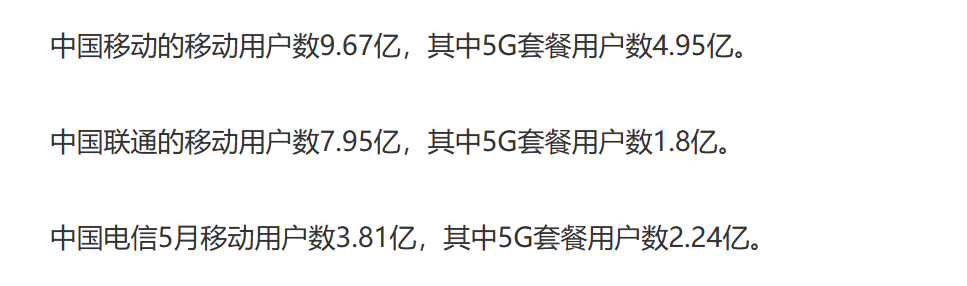

### 中国联通市占率 37.1%
### 2020年10月比2019年同期人口减少48.7%，需要进行折算，即占比51.3%

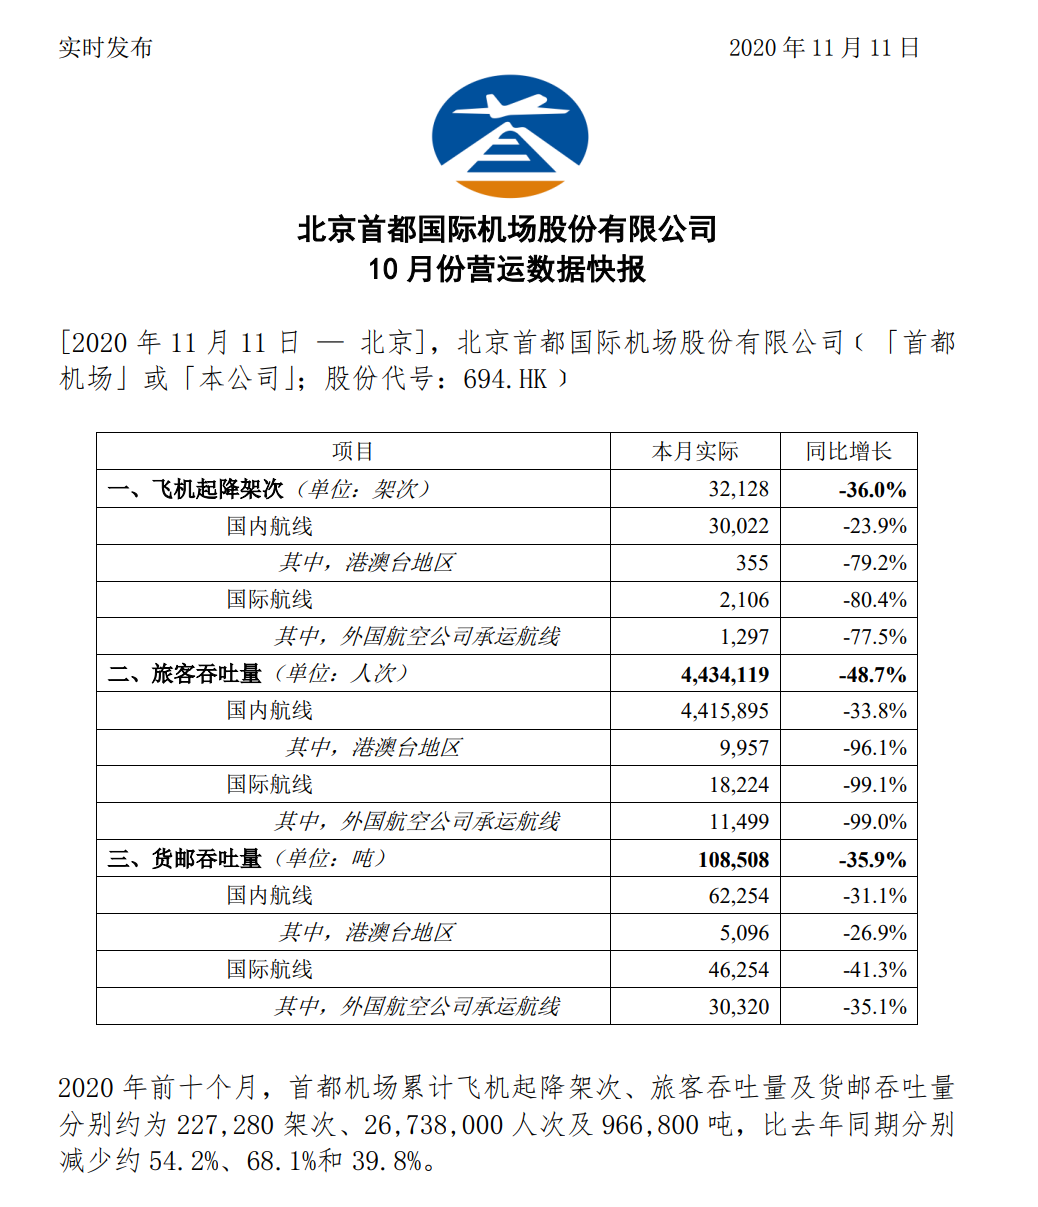

In [14]:
path="./data_beijing"
files=os.listdir(path)
path=os.path.relpath(path)

#北京首都国际机场的经纬度范围：
minlat=40.046353
maxlat=40.099383
minlng=116.585709
maxlng=116.630768
rectangle_polygon = Polygon([(minlng, minlat), (maxlng, minlat), (maxlng, maxlat), (minlng, maxlat)])

num_x_division=1
num_y_division=2
result=pd.DataFrame()

bound=[]
for file in files:
    data_path=os.path.join(path,file)
    data=pd.read_csv(data_path)
    data=trip_extraction(data)
    data=data[data['line_dis']>0].copy()
    min_slng,max_slng,minslat,max_slat=data['sclng'].min(),data['sclng'].max(),data['sclat'].min(),data['sclat'].max()
    min_elng,max_elng,minelat,max_elat=data['eclng'].min(),data['eclng'].max(),data['eclat'].min(),data['eclat'].max() 
    bound.append([min_slng,max_slng,minslat,max_slat])
    bound.append([min_elng,max_elng,minelat,max_elat])
bound=pd.DataFrame(bound,columns=['lng_min','lng_max','lat_min','lat_max'])
bound_lng=[bound['lng_min'].min(),bound['lng_max'].max()]
bound_lat=[bound['lat_min'].min(),bound['lat_max'].max()]

for file in files:
    data_path=os.path.join(path,file)
    data=pd.read_csv(data_path)
    gpd.options.use_pygeos=True
    
    trip_data=trip_extraction(data)
    trip_data=trip_data[trip_data['line_dis']>0].copy()
    start_temp,end_temp=data_clean(trip_data)
    print("ok")
    gpd.options.use_pygeos=False
    start=start_temp.copy()
    end=end_temp.copy()
    
    start,end=point_to_zone(start,end)
    
    all_trip=calculate_demand(start,end)
    print(all_trip.shape)
    
    result=pd.concat([result,all_trip],ignore_index=True)
    result=final_calculate(result)


    

(21117465, 6)
(20720362, 6)
(21170934, 6)
(20773828, 6)
(21078701, 6)
(20681671, 6)
(21097764, 6)
(20700737, 6)
(21105659, 6)
(20708630, 6)
(21070578, 6)
(20673522, 6)
(21106822, 6)
(20709720, 6)
(21133319, 6)
(20736257, 6)
(21086919, 6)
(20689771, 6)
(21119114, 6)
(20722073, 6)
(21089885, 6)
(20692856, 6)
(21069908, 6)
(20672904, 6)
(21077798, 6)
(20680811, 6)
(21136977, 6)
(20739876, 6)
(21077670, 6)
(20680592, 6)
(21113101, 6)
(20716066, 6)
(21097774, 6)
(20700733, 6)
(21149347, 6)
(20752274, 6)
(21075156, 6)
(20678084, 6)
(21048666, 6)
(20651558, 6)
(21092916, 6)
(20695928, 6)
(21082299, 6)
(20685231, 6)
(21105087, 6)
(20708069, 6)
(21007410, 6)
(20610393, 6)
(21119224, 6)
(20722118, 6)
(21083629, 6)
(20686529, 6)
(21100415, 6)
(20703404, 6)
(21092213, 6)
(20695155, 6)
(21119153, 6)
(20722076, 6)
(20998216, 6)
(20601174, 6)
(21074345, 6)
(20677298, 6)
(21090960, 6)
(20693897, 6)
(21151435, 6)
(20754341, 6)
(21049080, 6)
(20652002, 6)
(21130194, 6)
(20733118, 6)
(21150431, 6)
(20753

E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21117465, 6)
(20720362, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(26287, 13)
(25340, 13)
ok
(20568, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21170934, 6)
(20773828, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(26377, 13)
(25080, 13)
ok
(20670, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21078701, 6)
(20681671, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(25996, 13)
(25398, 13)
ok
(20405, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21097764, 6)
(20700737, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(26034, 13)
(25043, 13)
ok
(20461, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21105659, 6)
(20708630, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(26278, 13)
(25305, 13)
ok
(20352, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21070578, 6)
(20673522, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(26019, 13)
(25143, 13)
ok
(20614, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21106822, 6)
(20709720, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(26190, 13)
(25261, 13)
ok
(20553, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21133319, 6)
(20736257, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(26466, 13)
(25459, 13)
ok
(20608, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21086919, 6)
(20689771, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(26559, 13)
(25513, 13)
ok
(20820, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21119114, 6)
(20722073, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(26073, 13)
(25146, 13)
ok
(20595, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21089885, 6)
(20692856, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(26060, 13)
(25100, 13)
ok
(20531, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21069908, 6)
(20672904, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(25944, 13)
(24848, 13)
ok
(20438, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21077798, 6)
(20680811, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(25716, 13)
(24532, 13)
ok
(20367, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21136977, 6)
(20739876, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(25941, 13)
(25156, 13)
ok
(20442, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21077670, 6)
(20680592, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(26385, 13)
(25285, 13)
ok
(20640, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21113101, 6)
(20716066, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(25925, 13)
(25147, 13)
ok
(20528, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21097774, 6)
(20700733, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(26375, 13)
(25446, 13)
ok
(20749, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21149347, 6)
(20752274, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(25947, 13)
(24946, 13)
ok
(20476, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21075156, 6)
(20678084, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(25860, 13)
(24928, 13)
ok
(20544, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21048666, 6)
(20651558, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(26555, 13)
(25373, 13)
ok
(20668, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21092916, 6)
(20695928, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(26347, 13)
(25460, 13)
ok
(20582, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21082299, 6)
(20685231, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(26217, 13)
(25512, 13)
ok
(20669, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21105087, 6)
(20708069, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(26177, 13)
(25399, 13)
ok
(20611, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21007410, 6)
(20610393, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(26234, 13)
(25187, 13)
ok
(20575, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21119224, 6)
(20722118, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(26017, 13)
(25152, 13)
ok
(20500, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21083629, 6)
(20686529, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(26185, 13)
(25092, 13)
ok
(20501, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21100415, 6)
(20703404, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(26042, 13)
(24974, 13)
ok
(20514, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21092213, 6)
(20695155, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(25878, 13)
(25203, 13)
ok
(20391, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21119153, 6)
(20722076, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(26382, 13)
(25282, 13)
ok
(20674, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(20998216, 6)
(20601174, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(26405, 13)
(25328, 13)
ok
(20798, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21074345, 6)
(20677298, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(25833, 13)
(25073, 13)
ok
(20485, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21090960, 6)
(20693897, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(25782, 13)
(25051, 13)
ok
(20552, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21151435, 6)
(20754341, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(26271, 13)
(25112, 13)
ok
(20635, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21049080, 6)
(20652002, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(25867, 13)
(25046, 13)
ok
(20521, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21130194, 6)
(20733118, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(26218, 13)
(25019, 13)
ok
(20687, 9)


E:\Anaconda\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migr

(21150431, 6)
(20753279, 6)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10692\1382740732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['delta_time']=new_data['etime']-new_data['stime']


(26497, 13)
(25204, 13)
ok
(20804, 9)


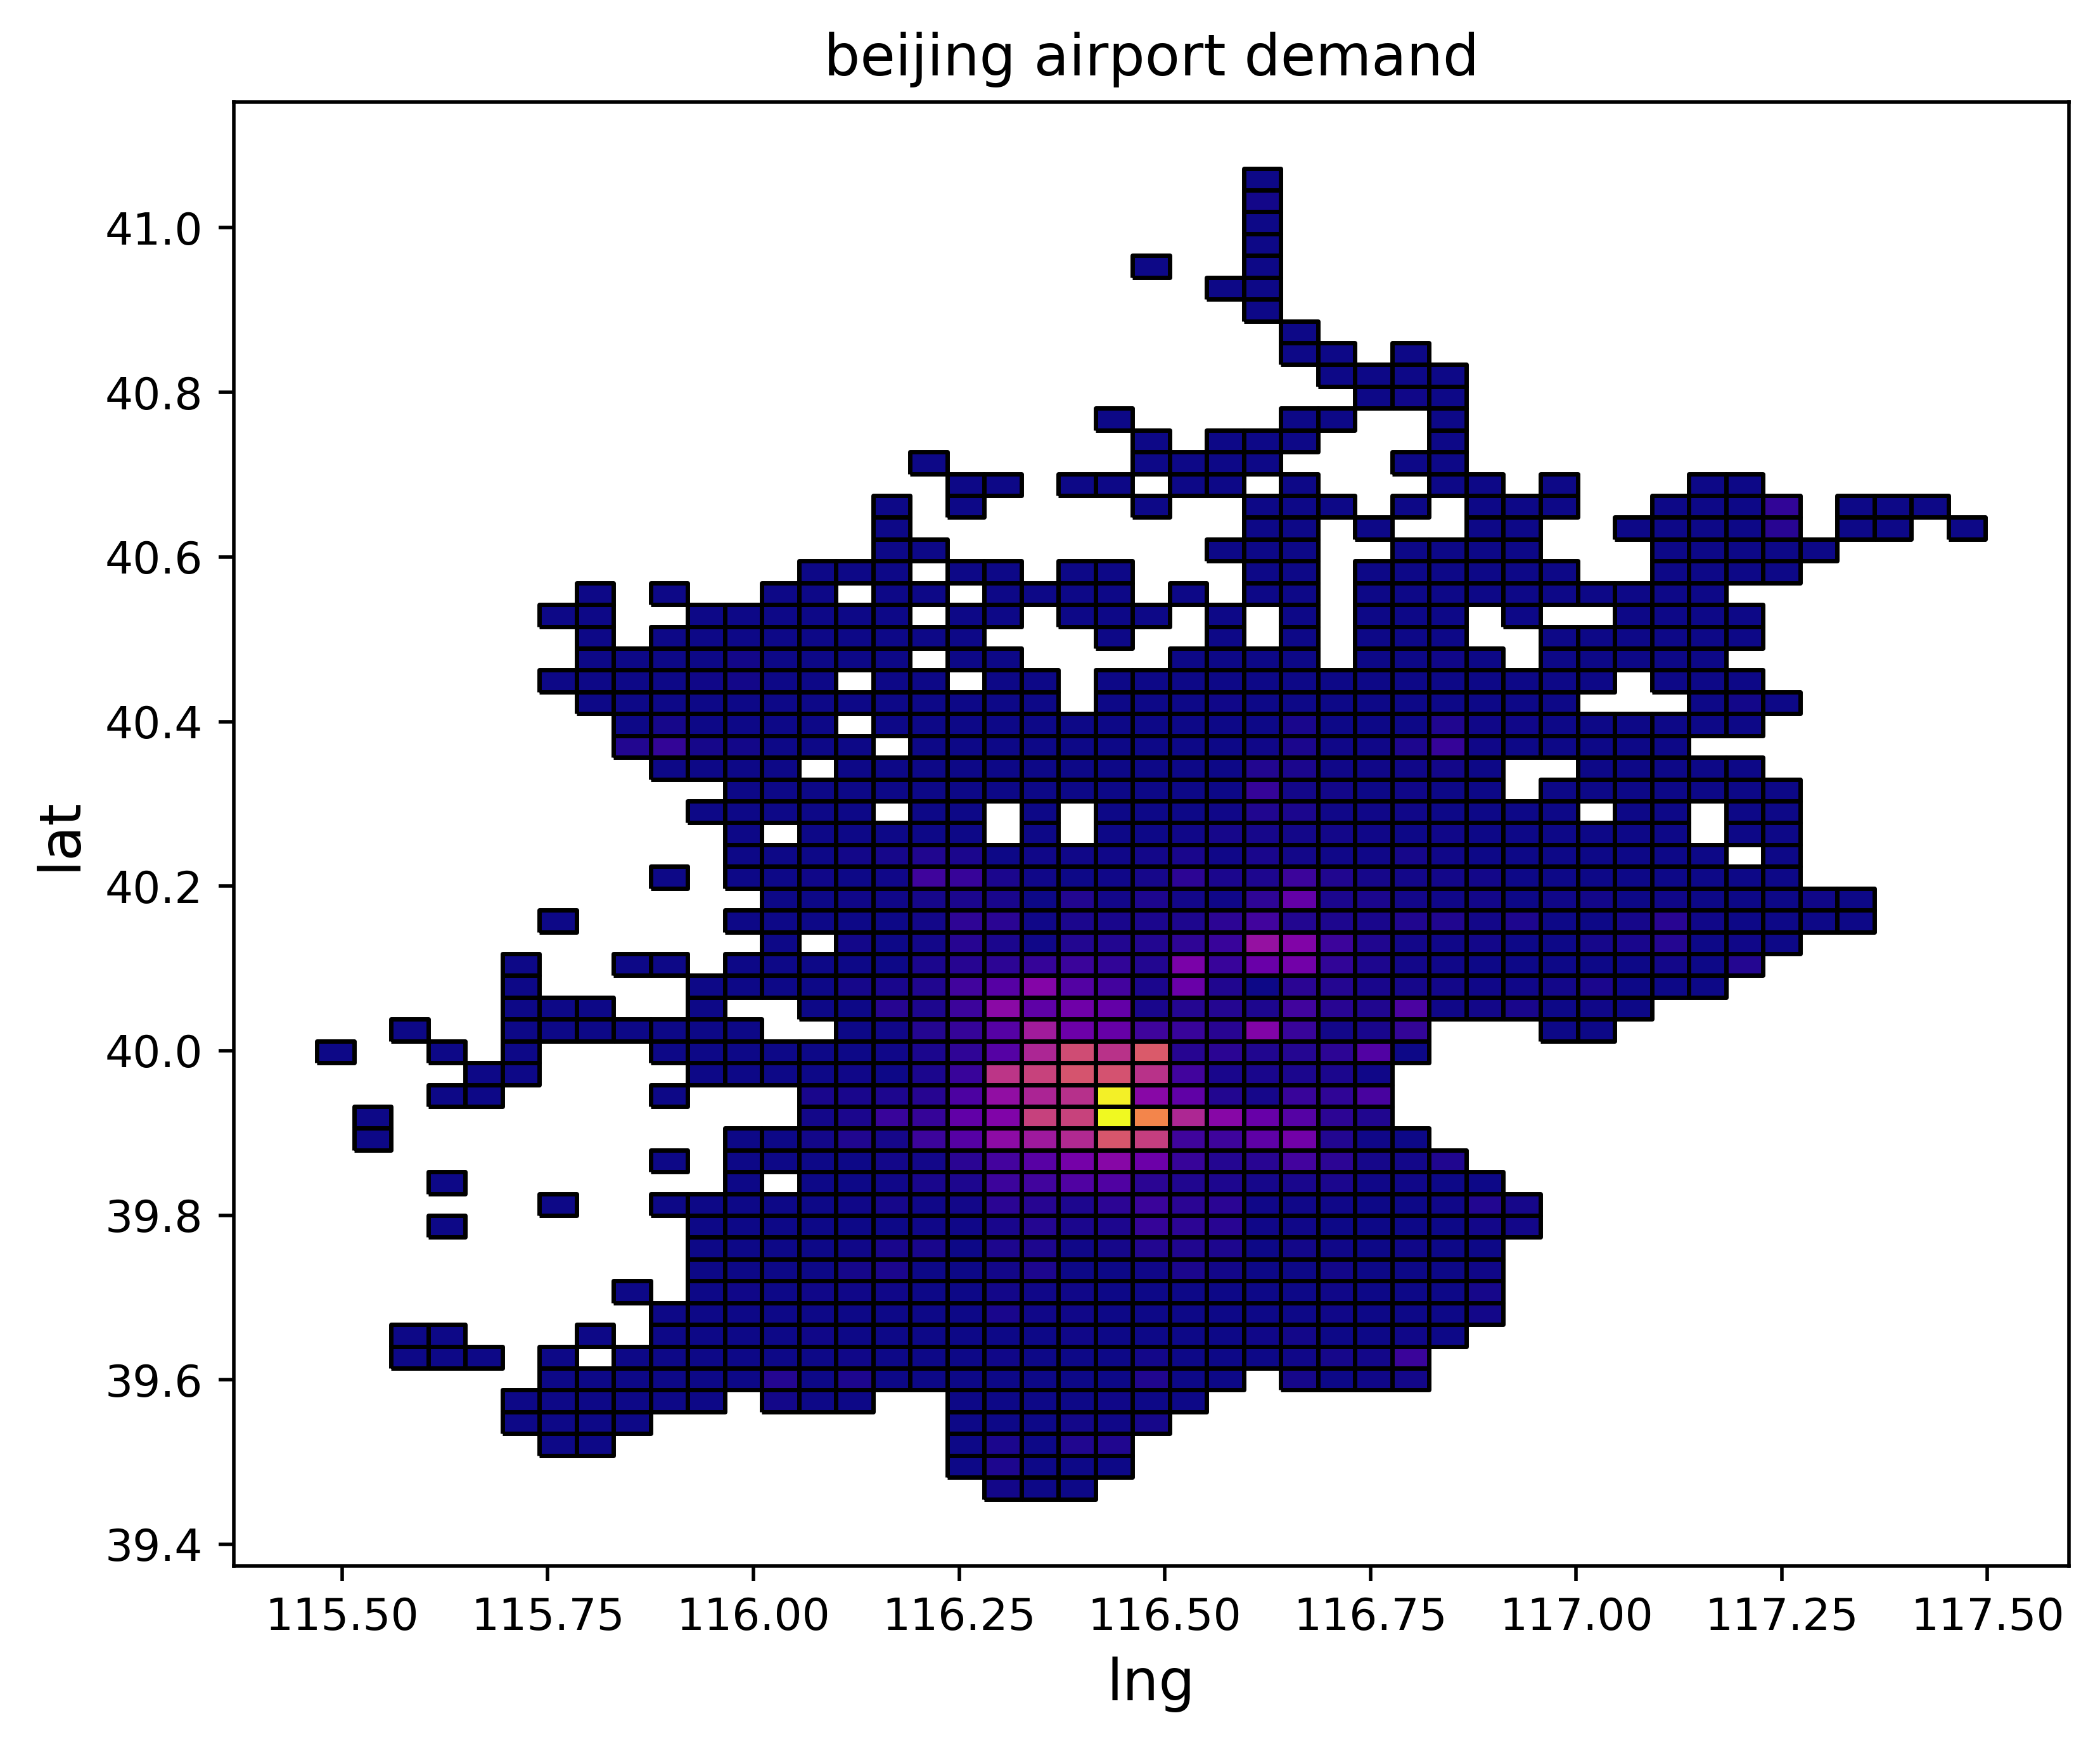

In [15]:
data_visualization(result)

In [34]:
airport_bound=[minlng,maxlng,minlat,maxlat]
data_bound=[bound_lng[0],bound_lng[1],bound_lat[0],bound_lat[1]]
result_output(result,airport_bound,num_x_division,num_y_division,data_bound)